In [1]:
# if no configuration path is specified, 
# interactive parameters (in the next cell) will be used
config_path = None 

In [2]:
# PARAMETER CELL (needed for papermill)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras as K
import fnmatch, os
import activelearning as al
from activelearning.config import cfg

al.utils.init(config_path)

# Interactive parameters (override config)
if config_path is None:
    
    config_path = "configs/cavities/cavities.yaml"
    # cfg.merge_from_file("configs/cavities/six-random-small-noise-couplingrandom.yaml")
    # cfg.merge_from_file("configs/cavities/six-random-small-noise-paper.yaml")
    # config_path = "configs/qubits-binomial-4.yaml"
    # config_path = "configs/linear-toy.yaml"
    cfg.merge_from_file(config_path)
    
    
    cfg.PATH.EXPERIMENT_NAME = "default"
    cfg.TRAINING.N_MEASUREMENTS = 1
    cfg.ADVISOR.N_TRAIN = 500
    # cfg.ADVISOR.BATCH_SIZE = 250
    
    # cfg.SYSTEM.TYPE = "Cavities"
    # # cfg.SYSTEM.X_RANGE = [-6,6]
    cfg.SYSTEM.DIM_LAMBDA = 6
    cfg.SYSTEM.BINOMIAL.N_COUNTS = 1
    
    cfg.ADVISOR.NAME = "InformationGainAdvisor"
    # cfg.ADVISOR.NAME = "UniformGridAdvisor"
    cfg.PATH.SUBLABEL = cfg.ADVISOR.NAME
    cfg.PARALLEL.ENABLED = False
    cfg.PARALLEL.ENABLED = True
    cfg.PARALLEL.N_NODES = 10
    cfg.PARALLEL.PROFILE_ID = "parallel_jpt"
    # information gain curve for plotting (requires parallelization):
    cfg.METRICS.EXP_IG.N_TRAIN = 0 
    
    al.utils.init_output_directories()
    al.logger.warning("No configuration path specified. Loading default + notebook additional settings.")

%load_ext autoreload
%autoreload 2

2023-06-27 09:21:24.221254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[INFO] 2023-06-27 09:21:41,373 utils.py:36-init_logfile Running job #None
[INFO] 2023-06-27 09:21:41,374 utils.py:37-init_logfile Log file has been created in outputs/default_experiment/logs/default.log
[WARNING] 2023-06-27 09:21:41,388 460495741.py:44-<module> No configuration path specified. Loading default + notebook additional settings.


Creating directories...
Creating directories...


In [4]:
# Resume checkpoint
path_list = sorted(fnmatch.filter(os.listdir(al.config.Directories().PATH_OUTPUT_MODELS), 
                          f'{cfg.PATH.SUBLABEL}*'))

if len(path_list)!=0 and cfg.PATH.EXPERIMENT_NAME !="default":
    al.logger.info("Loading checkpoint...")
    label= path_list[-1]

    if cfg.PARALLEL.ENABLED:
        parallel = al.parallel.Parallel(cfg.PARALLEL.CLUSTER_ID,n_nodes=cfg.PARALLEL.N_NODES)
    else: parallel = None

    system, learner, advisor = al.utils.load_all(
        al.utils.h5_get_model_path(label), parallel=parallel, load_discrete=False
    )
    
# New experiment run
else: 
    system = al.systems.get_system_from_name(cfg.SYSTEM.TYPE)(
                dim_lambda=cfg.SYSTEM.DIM_LAMBDA,
                type_lambda=cfg.SYSTEM.TYPE_LAMBDA,
                real_lambda=cfg.SYSTEM.REAL_LAMBDA,
                sigma_noise=cfg.SYSTEM.SIGMA_NOISE,
                x_range=cfg.SYSTEM.X_RANGE,
                j_coupling=not cfg.SYSTEM.COUPLING_RANDOM and cfg.SYSTEM.COUPLING,
                n_counts=cfg.SYSTEM.BINOMIAL.N_COUNTS)

    learner = al.learners.BayesLearner.from_default(system)

    # # Old implementation only for testing
    # if cfg.LEARNER.POSTERIOR.TYPE=="Gaussian":
    #     learner.posterior = al.distributions.ConditionalMultivariateGaussian(
    #         dim=system.dim_lambda,
    #         dim_conditions=system.dim_y)

    if cfg.PARALLEL.ENABLED:
        parallel = al.parallel.Parallel(cfg.PARALLEL.CLUSTER_ID,n_nodes=cfg.PARALLEL.N_NODES)
    else: parallel = None

    advisor = al.advisors.get_advisor_from_name(cfg.ADVISOR.NAME)(
        learner=learner,
        starting_x=0,
        n_train=cfg.ADVISOR.N_TRAIN,
        batch_size=cfg.ADVISOR.BATCH_SIZE,
        parallel=parallel)

    label = f"{cfg.PATH.SUBLABEL}-{len(learner.history):03d}"
    al.utils.save_all(al.utils.h5_get_model_path(label), system, learner, advisor)

2023-06-27 09:21:46.513948: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22793 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5
/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Job submitted with job id: '6500062'
Starting 10 engines with <class 'ipyparallel.cluster.launcher.SlurmEngineSetLauncher'>
Job submitted with job id: '6500063'


  0%|          | 0/10 [00:00<?, ?engine/s]

[INFO] 2023-06-27 09:22:29,291 parallel.py:71-__init__ Cluster parallel_jpt/jupyter has been initialized with 10 nodes.
[INFO] 2023-06-27 09:22:29,397 utils.py:112-save_all Model saved as outputs/default/models/InformationGainAdvisor-000.hdf5.


2023-06-27 09:22:29.859755: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x227e4310


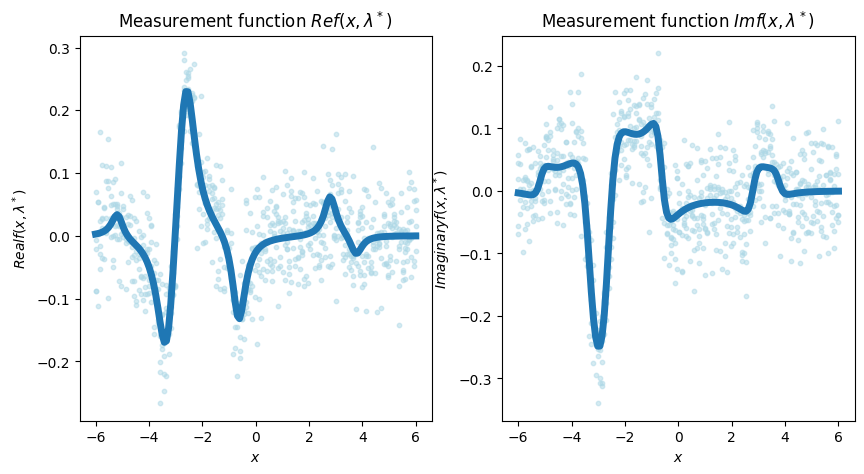

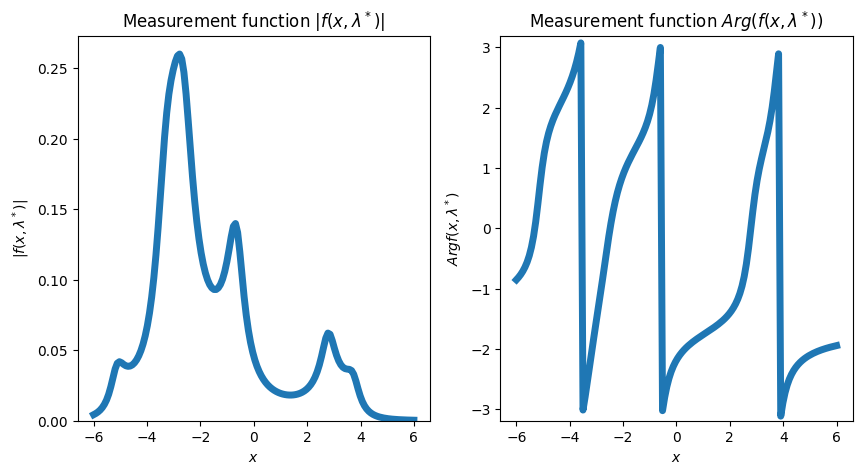

In [5]:
system.plot_response()

In [6]:
for i in range(cfg.TRAINING.N_MEASUREMENTS):
    label = f"{cfg.PATH.SUBLABEL}-{len(learner.history)+1:03d}"
    al.logger.info(f"Starting measurement {len(learner.history)+1:03d}")

    tf_measure_x = advisor.suggest_next_measurement()
    tf_measure_y = tf.convert_to_tensor(system.measure(tf_measure_x), K.backend.floatx())
    learner.metrics.evaluate(tf_new_y_measure=tf_measure_y)

    learner.apply_measurement(tf_measure_x, tf_measure_y)
    al.utils.save_all(al.utils.h5_get_model_path(label), system, learner, advisor)

Execution finished.


/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
[INFO] 2023-06-27 09:23:44,495 learners.py:221-apply_measurement Updating prior.
[INFO] 2023-06-27 09:23:44,535 utils.py:112-save_all Model saved as outputs/default/models/InformationGainAdvisor-001.hdf5.


In [7]:
if parallel is not None: parallel.stop()

Stopping controller
Controller stopped: {'job_id': '6500062', 'output': ''}
Stopping engine(s): 1687850510
engine set stopped 1687850510: {'job_id': '6500063', 'output': ''}


[INFO] 2023-06-27 09:23:48,141 parallel.py:80-stop Cluster parallel_jpt/jupyter has been stopped.


In [8]:
exit()

----

Below are some plots useful for interactive analysis

TODO: All these plots could be moved in the analysis notebook!

In [ ]:
plt.plot(advisor.training_history.optimal_xs)

In [ ]:
plt.plot(np.array(parallel["advisor.training_history.optimal_xs"]).T)

In [ ]:
plt.plot(np.array(parallel["advisor.training_history.information_gains"]).T)

Test parameter dependence of the response function with a given prior

In [ ]:
learner.prior = al.distributions.MultivariateGaussian(6,tf.cast(tf.math.real(system.tf_real_lambda), K.backend.floatx()), 
                                                                             sigma=tf.eye(6, dtype=K.backend.floatx())*0.0001)

learner.plot_measurement_curve(label)

In [ ]:
# plt.plot(*learner.metrics[al.metrics.DiscreteExpectedInformationGainCurve.__name__].history[-1].T)
plt.plot(*np.array(learner.metrics[al.metrics.ExpectedInformationGainCurve.__name__].history[-1]).T)


In [ ]:
plt.plot(*np.array(learner.metrics[al.metrics.OutputKullbackLeibler.__name__].history[0]).T)
plt.plot(*np.array(learner.metrics[al.metrics.OutputKullbackLeibler.__name__].history[1]).T)

plt.plot(*np.array(learner.metrics[al.metrics.OutputKullbackLeibler.__name__].history[-1]).T)


In [ ]:
plt.plot(advisor.training_history.information_gains[:])

In [ ]:
plt.plot(advisor.training_history.optimal_xs)


In [ ]:
ls =   np.linspace(-5.5,5.5,150)
vals = []
for l in ls:
    lmbds = tf.convert_to_tensor([system.tf_real_lambda.numpy()[0],l, *system.tf_real_lambda.numpy()[2:]],K.backend.floatx())
    x = -4.5
    exp = system.tf_f(tf.convert_to_tensor([x], K.backend.floatx()), tf_lambda=system.tf_real_lambda)
    vals.append([learner.likelihood.prob(exp,
                        tf_x =tf.convert_to_tensor([x],K.backend.floatx()), tf_lambda=lmbds)])
                        
plt.plot(ls,np.array(vals).squeeze())